## FC 과제
팀 : 김효빈, 박성영, 배세은

## 과제 수행 방식
먼저 Baseline Model 코드를 작성 후 성능향상에 도움을 줄 것 같은 방식을 추가한 후 성능을 비교하였습니다.

모든 결과를 비교하기 위해 각 모델의 실험결과를 csv파일로 저장하여 마지막에 한 번에 시각화하였습니다.  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# 1. Custom dataset class 구현

- STL-10 데이터셋은 96 * 96 * 3의 해상도로 cifar보다 크지만 학습 데이터의 수가 5000으로 적은 수의 데이터로 구성되어있는 것을 확인하였습니다.
- data transform으로 RandomHorizontalFlip과 같은 공간적 변형을 수행하려고 했으나 FCN의 구조 특성상 데이터를 Flatten 시켜 공간적 변형에 대한 이점이 적기 때문에 수행하지 않았습니다.

In [ ]:
import os
import urllib.request
import tarfile
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch
import random
import numpy as np

# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# STL - 10 데이터셋의 URL과 다운로드 경로 지정
DATA_URL = "https://cs.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
DATA_DIR = "./stl10_data"

# 데이터셋 다운로드 및 압축 해제 함
def download_and_extract_data(url, dest_dir):
    # 데이터 저장 디렉토리 생성
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    tar_path = os.path.join(dest_dir, "stl10_binary.tar.gz")

    # 데이터셋이 다운로드 되어있지 않은 경우 다운로드 수행하기
    if not os.path.exists(tar_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, tar_path)
        print("Download complete.")

    # 다운로드한 데이터셋 압축 해제
    print("Extracting dataset...")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=dest_dir)
    print("Extraction complete.")

# 데이터셋을 pytorch에서 사용하는 dataset 형식으로 정의하는 class
class STL10Dataset(Dataset):
    def __init__(self, data_path, split="train", transform=None):
        self.data_path = data_path
        self.split = split
        self.transform = transform
        self.images, self.labels = self.load_data()

    # 데이터 로드 함수
    # STL-10 dataset은 효율적인 저장과 빠른 읽기를 위해 Binary 형식으로 되어있음
    def load_data(self):
        if self.split == "train":
            images_file = os.path.join(self.data_path, "stl10_binary", "train_X.bin")
            labels_file = os.path.join(self.data_path, "stl10_binary", "train_y.bin")
        else:
            images_file = os.path.join(self.data_path, "stl10_binary", "test_X.bin")
            labels_file = os.path.join(self.data_path, "stl10_binary", "test_y.bin")

        images = self._read_images(images_file)
        labels = self._read_labels(labels_file)
        return images, labels

    # 레이블 데이터를 읽는 함수
    # 밑에 있는 _read_images와 _read_labels 함수를 통해 파일을 읽고 tensor 형태로 변환하는 과정이 필요
    def _read_images(self, filepath):
        with open(filepath, "rb") as f:
            images = f.read()
        images = torch.tensor(bytearray(images), dtype=torch.uint8).view(-1, 3, 96, 96)
        return images

    def _read_labels(self, filepath):
        with open(filepath, "rb") as f:
            labels = f.read()
        # STL-10은 1~10까지의 label로 되어있는데 torch에서는 label을 0부터 보기 때문에 -1을 해줌
        return torch.tensor(bytearray(labels), dtype=torch.long) - 1

    def __len__(self):
        return len(self.images)

    # DataLoader가 미니배치를 생성할 때 호출됨
    def __getitem__(self, idx):
        # 요청한 데이터의 인덱스 이미지를 가져옴
        image = self.images[idx].permute(1, 2, 0).numpy()
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image.view(-1), label  # 이미지 1차원 벡터로 변경

set_seed(42)  # 원하는 시드 값 설정

# 랜덤 제너레이터 생성 및 시드 설정
generator = torch.Generator().manual_seed(42)

# 데이터 다운로드
download_and_extract_data(DATA_URL, DATA_DIR)

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 밝기, 대비, 채도, 색상 변경
    transforms.ToTensor(), # 이미지를 tensor로 변환
])

# Train/Validation 데이터 split
full_train_dataset = STL10Dataset(DATA_DIR, split="train", transform=transform)
# 9:1 = Train : Val
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)  # 고정된 시드 기반으로 데이터 분할

# Test Dataset
test_dataset = STL10Dataset(DATA_DIR, split="test", transform=transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 확인
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Download complete.
Extracting dataset...
Extraction complete.
Train Dataset Size: 4500
Validation Dataset Size: 500
Test Dataset Size: 8000


#2. Base Model

- Base Model로는 hidden layer를 2개 쌓고 사이에 ReLU를 넣은 일반적인 FC모델을 사용하였습니다.
- optimizer로 AdamW를 사용하였습니다.
- Early Stopping을 사용하여 overfitting을 막았습니다.
- Test Accuracy가 39.31%로 나오는 것을 확인하였습니다.

In [ ]:
class Fc(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Fc, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# 모델, 손실 함수, 옵티마이저 정의
input_size = 96 * 96 * 3
hidden_size = [512, 256]
output_size = 10

model = Fc(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# 학습 함수
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 학습 루프
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# early stopping
patience = 10
best_acc = 0
patience_counter = 0

combination_name = "base_model"

num_epochs = 80
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Early stopping 체크
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "fc_best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

    # 결과 저장
    results['combination'].append(combination_name)
    results['epoch'].append(epoch + 1)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

# 모든 에포크 종료 후 결과를 CSV로 저장
save_results_to_csv(results, filename='experiment_results.csv')
print("Experiment results saved to 'experiment_results.csv'")



Epoch [1/80]
Train Loss: 2.4374, Train Accuracy: 19.44%
Validation Loss: 1.9584, Validation Accuracy: 29.20%
Test Loss: 1.9588, Test Accuracy: 26.60%
Epoch [2/80]
Train Loss: 1.9197, Train Accuracy: 28.00%
Validation Loss: 1.8864, Validation Accuracy: 28.60%
Test Loss: 1.8976, Test Accuracy: 27.73%
Epoch [3/80]
Train Loss: 1.8403, Train Accuracy: 31.67%
Validation Loss: 1.9554, Validation Accuracy: 26.00%
Test Loss: 1.9417, Test Accuracy: 27.35%
Epoch [4/80]
Train Loss: 1.7894, Train Accuracy: 33.96%
Validation Loss: 1.7983, Validation Accuracy: 34.60%
Test Loss: 1.7934, Test Accuracy: 32.84%
Epoch [5/80]
Train Loss: 1.7195, Train Accuracy: 36.51%
Validation Loss: 1.7704, Validation Accuracy: 34.40%
Test Loss: 1.7796, Test Accuracy: 31.94%
Epoch [6/80]
Train Loss: 1.6874, Train Accuracy: 37.53%
Validation Loss: 1.8262, Validation Accuracy: 33.60%
Test Loss: 1.8282, Test Accuracy: 32.73%
Epoch [7/80]
Train Loss: 1.6532, Train Accuracy: 38.58%
Validation Loss: 1.7367, Validation Accuracy

## Dropout과 STepLR 실험
저희는 dropout과 STepLR을 base모델에 포함하였을 때 성능이 높아질 것을 기대하고 각각 추가하여 실험을 진행하였습니다.

#2 - 1. STepLR 사용

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

class Fc(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Fc, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
        )
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# 모델, 손실 함수, 옵티마이저 정의
input_size = 96 * 96 * 3
hidden_size = [512, 256]
output_size = 10

model = Fc(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# 스케줄러 정의
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 함수
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 학습 루프
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# early stopping
patience = 10
best_acc = 0
patience_counter = 0

combination_name = "StepLR"

num_epochs = 80
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # 학습률 업데이트
    scheduler.step()

    # Early stopping 체크
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "fc_best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

    # 결과 저장
    results['combination'].append(combination_name)
    results['epoch'].append(epoch + 1)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

# 모든 에포크 종료 후 결과를 CSV로 저장
save_results_to_csv(results, filename='experiment_results.csv')
print("Experiment results saved to 'experiment_results.csv'")



Epoch [1/80]
Train Loss: 2.6195, Train Accuracy: 19.49%
Validation Loss: 1.9886, Validation Accuracy: 26.60%
Test Loss: 1.9820, Test Accuracy: 26.06%
Epoch [2/80]
Train Loss: 1.9095, Train Accuracy: 28.87%
Validation Loss: 2.0065, Validation Accuracy: 24.80%
Test Loss: 1.9994, Test Accuracy: 24.96%
Epoch [3/80]
Train Loss: 1.8274, Train Accuracy: 31.64%
Validation Loss: 1.8164, Validation Accuracy: 35.60%
Test Loss: 1.8151, Test Accuracy: 31.11%
Epoch [4/80]
Train Loss: 1.7783, Train Accuracy: 33.40%
Validation Loss: 1.8128, Validation Accuracy: 32.00%
Test Loss: 1.8042, Test Accuracy: 32.62%
Epoch [5/80]
Train Loss: 1.7291, Train Accuracy: 35.78%
Validation Loss: 1.7798, Validation Accuracy: 35.20%
Test Loss: 1.7921, Test Accuracy: 34.27%
Epoch [6/80]
Train Loss: 1.6799, Train Accuracy: 38.02%
Validation Loss: 1.7360, Validation Accuracy: 37.60%
Test Loss: 1.7597, Test Accuracy: 35.38%
Epoch [7/80]
Train Loss: 1.6314, Train Accuracy: 39.93%
Validation Loss: 1.6878, Validation Accuracy

#2 - 2. Dropout 사용

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

class Fc(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Fc, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# 모델, 손실 함수, 옵티마이저 정의
input_size = 96 * 96 * 3
hidden_size = [512, 256]
output_size = 10

model = Fc(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# 학습 함수
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 학습 루프
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# early stopping
patience = 10
best_acc = 0
patience_counter = 0

combination_name = "Dropout"

num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)

    model.eval()
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


    # Early stopping 체크
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "fc_best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

    # 결과 저장
    results['combination'].append(combination_name)
    results['epoch'].append(epoch + 1)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

# 모든 에포크 종료 후 결과를 CSV로 저장
save_results_to_csv(results, filename='experiment_results.csv')
print("Experiment results saved to 'experiment_results.csv'")



Epoch [1/80]
Train Loss: 2.5878, Train Accuracy: 14.20%
Validation Loss: 2.0697, Validation Accuracy: 21.60%
Test Loss: 2.0647, Test Accuracy: 21.11%
Epoch [2/80]
Train Loss: 2.1656, Train Accuracy: 16.38%
Validation Loss: 2.0559, Validation Accuracy: 18.00%
Test Loss: 2.0588, Test Accuracy: 20.01%
Epoch [3/80]
Train Loss: 2.1035, Train Accuracy: 18.02%
Validation Loss: 2.0648, Validation Accuracy: 18.00%
Test Loss: 2.0568, Test Accuracy: 18.61%
Epoch [4/80]
Train Loss: 2.0919, Train Accuracy: 18.82%
Validation Loss: 2.0453, Validation Accuracy: 20.60%
Test Loss: 2.0412, Test Accuracy: 22.24%
Epoch [5/80]
Train Loss: 2.0896, Train Accuracy: 17.78%
Validation Loss: 1.9541, Validation Accuracy: 24.40%
Test Loss: 1.9458, Test Accuracy: 24.73%
Epoch [6/80]
Train Loss: 2.0751, Train Accuracy: 18.16%
Validation Loss: 1.9879, Validation Accuracy: 19.00%
Test Loss: 1.9713, Test Accuracy: 22.19%
Epoch [7/80]
Train Loss: 2.0675, Train Accuracy: 18.47%
Validation Loss: 1.9427, Validation Accuracy

#2 - 3. dropout + StepLR 사용

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

class Fc(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Fc, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# 모델, 손실 함수, 옵티마이저 정의
input_size = 96 * 96 * 3
hidden_size = [512, 256]
output_size = 10

model = Fc(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# 스케줄러 정의
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 함수
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return total_loss / len(loader), accuracy

# 학습 루프
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# early stopping
patience = 10
best_acc = 0
patience_counter = 0

combination_name = "Dropout + StepLR"

num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)

    model.eval()
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # 학습률 업데이트
    scheduler.step()


    # Early stopping 체크
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "fc_best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

    # 결과 저장
    results['combination'].append(combination_name)
    results['epoch'].append(epoch + 1)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

# 모든 에포크 종료 후 결과를 CSV로 저장
save_results_to_csv(results, filename='experiment_results.csv')
print("Experiment results saved to 'experiment_results.csv'")



Epoch [1/80]
Train Loss: 2.4606, Train Accuracy: 15.47%
Validation Loss: 2.0855, Validation Accuracy: 18.80%
Test Loss: 2.0967, Test Accuracy: 19.32%
Epoch [2/80]
Train Loss: 2.1520, Train Accuracy: 16.47%
Validation Loss: 2.0180, Validation Accuracy: 21.80%
Test Loss: 2.0171, Test Accuracy: 22.27%
Epoch [3/80]
Train Loss: 2.1331, Train Accuracy: 16.73%
Validation Loss: 2.0757, Validation Accuracy: 21.00%
Test Loss: 2.0793, Test Accuracy: 20.20%
Epoch [4/80]
Train Loss: 2.1491, Train Accuracy: 16.42%
Validation Loss: 2.0440, Validation Accuracy: 22.60%
Test Loss: 2.0569, Test Accuracy: 20.00%
Epoch [5/80]
Train Loss: 2.0916, Train Accuracy: 17.29%
Validation Loss: 1.9876, Validation Accuracy: 21.00%
Test Loss: 1.9853, Test Accuracy: 20.60%
Epoch [6/80]
Train Loss: 2.0552, Train Accuracy: 18.60%
Validation Loss: 1.9987, Validation Accuracy: 21.00%
Test Loss: 1.9962, Test Accuracy: 22.79%
Epoch [7/80]
Train Loss: 2.0434, Train Accuracy: 18.93%
Validation Loss: 1.9797, Validation Accuracy

#3. 2에서 수행한 실험의 Training log 시각화

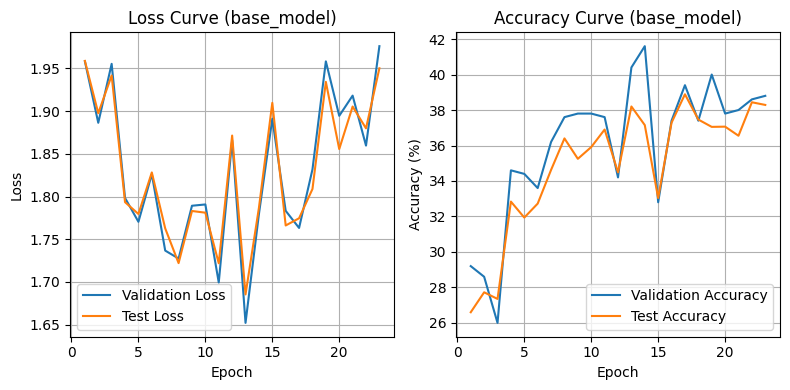

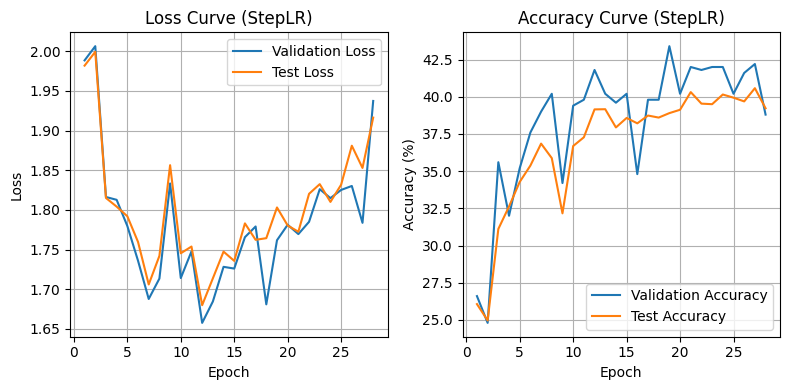

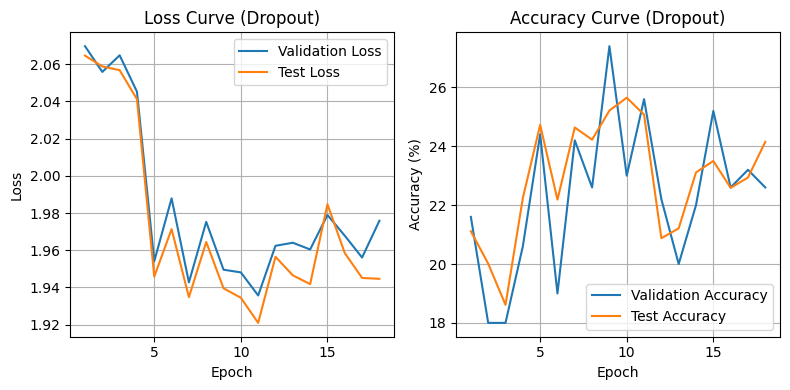

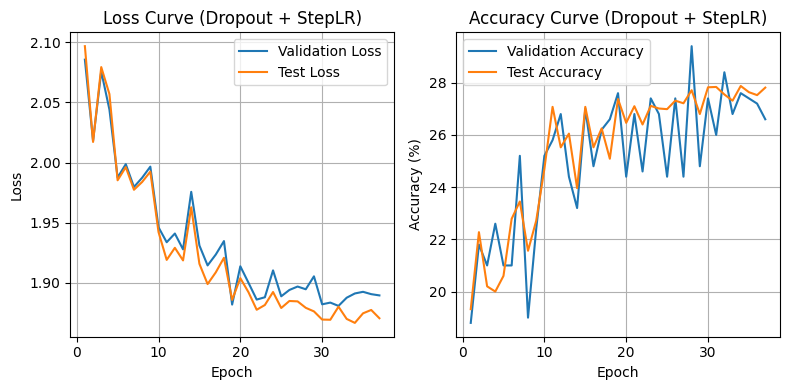

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로드
df = pd.read_csv('experiment_results.csv')


# 조합별 그래프 생성
for combination in df['Combination'].unique():
    filtered_df = df[df['Combination'] == combination]  # 조합별 데이터 필터링

    # 그래프 그리기 (2x1 Grid)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1행 2열 서브플롯

    # Loss Curve (Validation Loss & Test Loss)
    axes[0].plot(filtered_df['Epoch'], filtered_df['Validation Loss'], label='Validation Loss')
    axes[0].plot(filtered_df['Epoch'], filtered_df['Test Loss'], label='Test Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Loss Curve ({combination})')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy Curve (Validation Accuracy & Test Accuracy)
    axes[1].plot(filtered_df['Epoch'], filtered_df['Validation Accuracy'], label='Validation Accuracy')
    axes[1].plot(filtered_df['Epoch'], filtered_df['Test Accuracy'], label='Test Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'Accuracy Curve ({combination})')
    axes[1].legend()
    axes[1].grid(True)

    # 그래프 간격 조정
    plt.tight_layout()
    plt.show()


#4. Evaluation Result

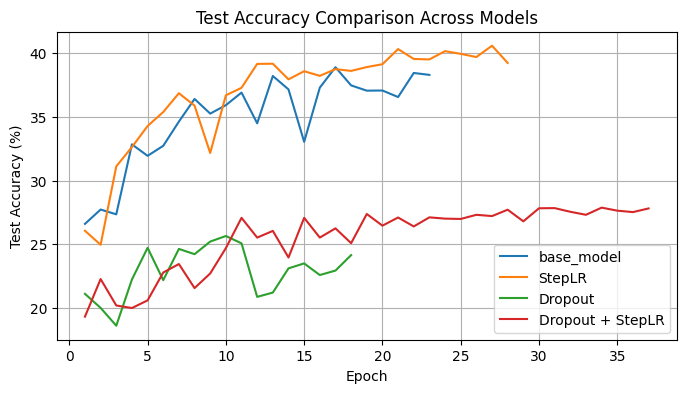

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로드
df = pd.read_csv('experiment_results.csv')

# 그래프 초기화
plt.figure(figsize=(8, 4))

# 모든 조합의 테스트 정확도를 시각화
for combination in df['Combination'].unique():
    filtered_df = df[df['Combination'] == combination]  # 조합별 데이터 필터링
    plt.plot(filtered_df['Epoch'], filtered_df['Test Accuracy'], label=combination)

# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison Across Models')
plt.legend()
plt.grid(True)
plt.show()


#5. 어려웠던 점, 분석 및 고찰





### linear model의 한계

- FCN은 공간 정보를 활용하지 못하고 각 픽셀을 독립적으로 처리하기 때문에 image와 같이 복잡한 데이터의 구조적 패턴을 충분히 표현하거나 학습할 수 없습니다.
> 따라서 아무리 노력해도 40%를 웃도는 정확도만 나오는 결과를 확인할 수 있었습니다.


- 데이터의 복잡한 분포를 표현할 수 없기 때문에, image task에서 model이 train data에는 적합하더라도 test data에 대해 일반화 성능이 크게 떨어짐을 확인할 수 있었습니다.


- 사용한 방법 외에 층을 더 깊게 쌓아도 보고 다양한 이미지 augmentation을 적용하는 등 다양한 방법을 적용하더라도 test accuracy가 향상되지 않았습니다.


- Early stopping을 적용했을 때에도, validation accuracy가 진동하여 학습을 멈추는 시점이 훈련 정확도가 충분히 높아지지 않은 상태에서 결정되었습니다.
> STL10처럼 데이터가 적은 경우, 검증 데이터의 작은 변화에도 early Stopping이 지나치게 민감하게 반응할 수 있음을 확인하였습니다.


- image 데이터는 고차원적이고 복잡한 정보를 담고 있으므로, Dropout으로 인해 유용한 정보가 손실될 경우 model 성능이 더욱 떨어질 수 있습니다.  
> 저희가 사용하였던 STL-10은 data의 수가 적고, linear model은 image task에 학습 능력이 부족하기 때문에, Dropout으로 인해 출력이 불안정해지고 수렴 속도가 느려짐을 확인하였습니다.


- StepLR은 학습률을 점진적으로 감소시키며 모델이 overfitting될 수 있는 위험을 줄여줍니다.
> 확실히 StepLR을 사용한 모델이 다른 모델들보다 안정적인 수렴을 하는 것을 확인할 수 있었고, StepLR을 추가한 모델이 가장 좋은 성능을 달성한 것을 확인할 수 있었습니다.
